In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (10, 7)
import seaborn as sns
sns.set(font="AppleGothic", 
        rc={"axes.unicode_minus":False})
import math

from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_boston

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# 보스턴 집값 데이터 불러와 데이터 프레임 생성
boston = load_boston()
boston_df = pd.DataFrame(boston['data'], columns=boston['feature_names'])
boston_df['MEDV'] = boston['target']
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [3]:
# 입출력 데이터 
x_data = boston_df.drop('MEDV', axis=1)
y_data = boston_df['MEDV']

In [4]:
# 훈련, 테스트 데이터
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=0)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((404, 13), (102, 13), (404,), (102,))

### 하이퍼 파라미터 튜닝 후 학습

In [42]:
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

In [50]:
# alpha 값(규제 값)을 변경하며 학습
param_grid = {
    'ridge__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
}
model_grid_ridge = GridSearchCV(model_ridge, param_grid, cv=kfold)
model_grid_ridge.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                          1000]})

In [51]:
# 가장 좋은 파라미터 값
model_grid_ridge.best_params_

{'ridge__alpha': 10}

In [52]:
# 가장 좋은 score
model_grid_ridge.best_score_

0.738681779610553

In [53]:
# 교차 검증 결과
model_grid_ridge.cv_results_

{'mean_fit_time': array([0.01212828, 0.00702245, 0.00704174, 0.00616693, 0.00731566,
        0.00775802, 0.00702107, 0.00712798]),
 'std_fit_time': array([0.0077471 , 0.00206377, 0.00166677, 0.00076601, 0.00172471,
        0.00249216, 0.00138905, 0.00190159]),
 'mean_score_time': array([0.00445871, 0.00299094, 0.00312269, 0.00327048, 0.00489843,
        0.00297968, 0.00294681, 0.0027823 ]),
 'std_score_time': array([0.00309127, 0.00092193, 0.00180784, 0.00145993, 0.00483839,
        0.00077937, 0.00085089, 0.00068792]),
 'param_ridge__alpha': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'ridge__alpha': 0.0001},
  {'ridge__alpha': 0.001},
  {'ridge__alpha': 0.01},
  {'ridge__alpha': 0.1},
  {'ridge__alpha': 1},
  {'ridge__alpha': 10},
  {'ridge__alpha': 100},
  {'ridge__alpha': 1000}],
 'split0_test_score': array([0.81245129, 0.

In [58]:
# 최적의 파라미터 값 적용한 모델 생성
best_model = model_grid_ridge.best_estimator_
best_model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=10))])

In [59]:
best_model.score(x_train, y_train), best_model.score(x_test, y_test)

(0.7720252703788119, 0.5791628807875255)

### 신축망(Elastic-Net)
- L1과 L2를 모두 사용
- ${\lambda}$ 값을 조절하여 L1과 L2 비중 조절

In [66]:
np.linspace(0.0001, 1001, 10)

array([1.00000000e-04, 1.11222311e+02, 2.22444522e+02, 3.33666733e+02,
       4.44888944e+02, 5.56111156e+02, 6.67333367e+02, 7.78555578e+02,
       8.89777789e+02, 1.00100000e+03])

In [69]:
# elasticnet 학습 
model_elastic = make_pipeline(StandardScaler(), ElasticNet())
param_grid = {
    'elasticnet__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'elasticnet__l1_ratio': np.arange(0.1, 1.1, 0.1)
}
model_grid_elastic = GridSearchCV(model_elastic, param_grid, cv=kfold)
model_grid_elastic.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('elasticnet', ElasticNet())]),
             param_grid={'elasticnet__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                               100, 1000],
                         'elasticnet__l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])})

In [70]:
model_grid_elastic.best_params_

{'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.1}

In [71]:
model_grid_elastic.best_score_

0.7378923582083488

In [75]:
model_grid_elastic.cv_results_

{'mean_fit_time': array([0.00952909, 0.00581117, 0.00648205, 0.00594954, 0.00626266,
        0.00630312, 0.00631311, 0.00583632, 0.00804641, 0.01200986,
        0.01139572, 0.00590582, 0.00792863, 0.00784142, 0.00755091,
        0.00613043, 0.00566936, 0.00616021, 0.00529022, 0.00615244,
        0.0061671 , 0.005864  , 0.00600803, 0.00555422, 0.00578682,
        0.00567212, 0.00592399, 0.00569093, 0.00560277, 0.00608196,
        0.0056273 , 0.00601361, 0.00600021, 0.00598683, 0.00592995,
        0.00609725, 0.00609808, 0.00559003, 0.00549214, 0.00531843,
        0.00538108, 0.0056411 , 0.00572007, 0.00598471, 0.00565472,
        0.00644903, 0.00667787, 0.00750144, 0.00672898, 0.00665436,
        0.00727677, 0.00782385, 0.00605049, 0.00573263, 0.00606899,
        0.00617054, 0.00634513, 0.00555778, 0.00540264, 0.00530748,
        0.00592699, 0.00572059, 0.00544345, 0.00580628, 0.00541418,
        0.00586545, 0.00544829, 0.00580168, 0.00573978, 0.00580461,
        0.00570278, 0.00613053,

In [73]:
best_model_elastic = model_grid_elastic.best_estimator_
best_model_elastic

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('elasticnet', ElasticNet(alpha=0.01, l1_ratio=0.1))])

In [74]:
best_model_elastic.score(x_train, y_train), best_model_elastic.score(x_test, y_test)

(0.7728257665722233, 0.5852052793842898)

### 과대적합(overfitting), 과소적합(underfitting)
- 과대적합: 모델이 훈련 데이터에 너무 잘 맞지만 일반성이 떨어진다
    - 훈련 데이터에 너무 잘맞아 그 외의 데이터에 대해 성능이 떨어진다
- 과소적합: 과대적합의 반대, 모델이 너무 단순해서 데이터의 내재된 구조를 학습하지 못할 때 발생

#### 과대적합, 과소적합 예시

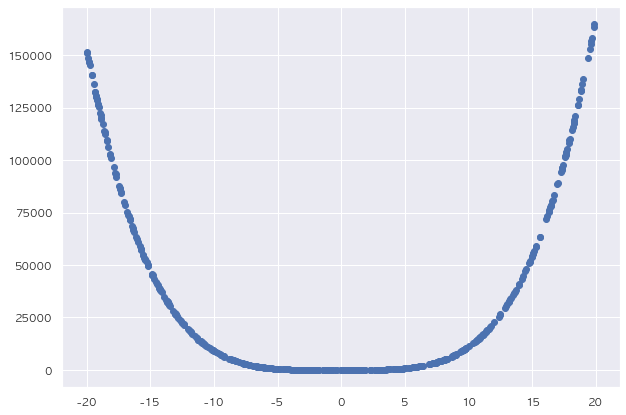

In [118]:
# 데이터 
sample_size = 500
x = np.random.uniform(-20, 20, sample_size).reshape(-1, 1)
y = x**4 + x**3 + x**2 + x + np.random.normal(0, 10, sample_size).reshape(-1, 1)
y = np.ravel(y)

# 데이터 시각화
plt.scatter(x, y)
plt.show()

In [119]:
# LinearRegressor 학습
model_lr = LinearRegression()
model_lr.fit(x, y)

LinearRegression()

In [124]:
# MLPRegressor 학습
model_nn = MLPRegressor(hidden_layer_sizes=(1000, 4), max_iter=5000, alpha=0.005, random_state=1, verbose=1)
model_nn.fit(x, y)

Iteration 1, loss = 1482412330.32094479
Iteration 2, loss = 1482380508.58965063
Iteration 3, loss = 1482342601.49177241
Iteration 4, loss = 1482294955.11559629
Iteration 5, loss = 1482239567.80503273
Iteration 6, loss = 1482183873.75705600
Iteration 7, loss = 1482120149.73122311
Iteration 8, loss = 1482053540.34199500
Iteration 9, loss = 1481983881.90016007
Iteration 10, loss = 1481905207.72128272
Iteration 11, loss = 1481820203.47218609
Iteration 12, loss = 1481730466.69834471
Iteration 13, loss = 1481631258.16520905
Iteration 14, loss = 1481519810.26620626
Iteration 15, loss = 1481403062.94155788
Iteration 16, loss = 1481271979.79745388
Iteration 17, loss = 1481124724.75446701
Iteration 18, loss = 1480970194.14213085
Iteration 19, loss = 1480797134.48397255
Iteration 20, loss = 1480612382.42157912
Iteration 21, loss = 1480413515.07697248
Iteration 22, loss = 1480195607.25024796
Iteration 23, loss = 1479949357.93529963
Iteration 24, loss = 1479693787.23300934
Iteration 25, loss = 1479

Iteration 203, loss = 653899967.48697460
Iteration 204, loss = 648064165.49827182
Iteration 205, loss = 642427602.65625501
Iteration 206, loss = 636560163.57563937
Iteration 207, loss = 630527754.71476126
Iteration 208, loss = 625173988.91459870
Iteration 209, loss = 619678488.91363907
Iteration 210, loss = 614058005.51064658
Iteration 211, loss = 608639179.43090189
Iteration 212, loss = 603256240.14067233
Iteration 213, loss = 598140289.85780549
Iteration 214, loss = 592592622.94968104
Iteration 215, loss = 587682486.06692016
Iteration 216, loss = 582500864.96973240
Iteration 217, loss = 577641646.31856108
Iteration 218, loss = 572677767.54793084
Iteration 219, loss = 567918807.87868440
Iteration 220, loss = 562803278.47289538
Iteration 221, loss = 558333981.76104248
Iteration 222, loss = 554022759.21038961
Iteration 223, loss = 549459991.63612068
Iteration 224, loss = 545076567.65736949
Iteration 225, loss = 540735757.08839250
Iteration 226, loss = 536524036.17956090
Iteration 227, l

Iteration 414, loss = 382546976.42007738
Iteration 415, loss = 382441158.72576094
Iteration 416, loss = 382339534.02116966
Iteration 417, loss = 382240728.93243670
Iteration 418, loss = 382144266.12534583
Iteration 419, loss = 382050840.05958050
Iteration 420, loss = 381966872.86674088
Iteration 421, loss = 381864657.21016151
Iteration 422, loss = 381769099.65613270
Iteration 423, loss = 381670625.42737573
Iteration 424, loss = 381576426.08828843
Iteration 425, loss = 381484396.50357240
Iteration 426, loss = 381387929.05509704
Iteration 427, loss = 381298252.28628618
Iteration 428, loss = 381201240.17707920
Iteration 429, loss = 381116528.81609535
Iteration 430, loss = 381016548.64820379
Iteration 431, loss = 380917767.34046203
Iteration 432, loss = 380827954.90320778
Iteration 433, loss = 380740568.22995067
Iteration 434, loss = 380635892.31482947
Iteration 435, loss = 380545205.81213260
Iteration 436, loss = 380467683.19542438
Iteration 437, loss = 380367322.97649956
Iteration 438, l

Iteration 621, loss = 364818098.46417910
Iteration 622, loss = 364737816.71767527
Iteration 623, loss = 364650186.95022672
Iteration 624, loss = 364579764.89773786
Iteration 625, loss = 364508050.36684340
Iteration 626, loss = 364423128.30327374
Iteration 627, loss = 364359163.70860320
Iteration 628, loss = 364275521.38144493
Iteration 629, loss = 364194810.39125317
Iteration 630, loss = 364112827.64676100
Iteration 631, loss = 364041792.32249039
Iteration 632, loss = 363956396.41860670
Iteration 633, loss = 363888793.97257513
Iteration 634, loss = 363814824.62654942
Iteration 635, loss = 363729381.59394735
Iteration 636, loss = 363668882.51311827
Iteration 637, loss = 363579131.93555671
Iteration 638, loss = 363485683.66649234
Iteration 639, loss = 363400009.38306814
Iteration 640, loss = 363330151.64535463
Iteration 641, loss = 363253857.16276133
Iteration 642, loss = 363166859.31307614
Iteration 643, loss = 363086131.87009239
Iteration 644, loss = 363012660.09156603
Iteration 645, l

Iteration 830, loss = 348584479.94891334
Iteration 831, loss = 348481192.09757262
Iteration 832, loss = 348402282.07149822
Iteration 833, loss = 348338449.38684881
Iteration 834, loss = 348252703.50105882
Iteration 835, loss = 348165281.70790982
Iteration 836, loss = 348088745.16708654
Iteration 837, loss = 348012071.74493879
Iteration 838, loss = 347939792.34810686
Iteration 839, loss = 347857043.75621295
Iteration 840, loss = 347783204.33722913
Iteration 841, loss = 347702718.01465350
Iteration 842, loss = 347618623.03238267
Iteration 843, loss = 347546308.65660888
Iteration 844, loss = 347479304.95649630
Iteration 845, loss = 347392072.70050371
Iteration 846, loss = 347313750.00497162
Iteration 847, loss = 347261635.48864645
Iteration 848, loss = 347175723.17069077
Iteration 849, loss = 347084805.93875957
Iteration 850, loss = 347019205.99732918
Iteration 851, loss = 346926292.08111876
Iteration 852, loss = 346856307.52965021
Iteration 853, loss = 346782283.44825768
Iteration 854, l

Iteration 1038, loss = 331774945.78919142
Iteration 1039, loss = 331688335.44774663
Iteration 1040, loss = 331615883.14541149
Iteration 1041, loss = 331545679.87958699
Iteration 1042, loss = 331416411.48343146
Iteration 1043, loss = 331340987.76264346
Iteration 1044, loss = 331271893.34626299
Iteration 1045, loss = 331162804.89855188
Iteration 1046, loss = 331085419.73988032
Iteration 1047, loss = 330989551.81795150
Iteration 1048, loss = 330913773.13066626
Iteration 1049, loss = 330818167.61535072
Iteration 1050, loss = 330762248.04860330
Iteration 1051, loss = 330660279.65648824
Iteration 1052, loss = 330575972.03339964
Iteration 1053, loss = 330498480.25418395
Iteration 1054, loss = 330387077.63843036
Iteration 1055, loss = 330303380.68400246
Iteration 1056, loss = 330207872.42504263
Iteration 1057, loss = 330161513.36000544
Iteration 1058, loss = 330054249.03607261
Iteration 1059, loss = 329952009.01915079
Iteration 1060, loss = 329899340.06481129
Iteration 1061, loss = 329785800.8

Iteration 1236, loss = 313442108.70162416
Iteration 1237, loss = 313339724.61013037
Iteration 1238, loss = 313263155.01196724
Iteration 1239, loss = 313154028.31494910
Iteration 1240, loss = 313034048.27433676
Iteration 1241, loss = 312937755.74835145
Iteration 1242, loss = 312855914.21765906
Iteration 1243, loss = 312721169.98340112
Iteration 1244, loss = 312616454.99117678
Iteration 1245, loss = 312514840.32262552
Iteration 1246, loss = 312416698.32695991
Iteration 1247, loss = 312376662.22734183
Iteration 1248, loss = 312227763.09219569
Iteration 1249, loss = 312116114.29996330
Iteration 1250, loss = 312011064.57072800
Iteration 1251, loss = 311913668.10653991
Iteration 1252, loss = 311812400.37898839
Iteration 1253, loss = 311758070.21155000
Iteration 1254, loss = 311613246.06063765
Iteration 1255, loss = 311511627.38422549
Iteration 1256, loss = 311416682.60253894
Iteration 1257, loss = 311315688.46160138
Iteration 1258, loss = 311202090.97097683
Iteration 1259, loss = 311108736.3

Iteration 1437, loss = 290323207.89411056
Iteration 1438, loss = 290188775.26575005
Iteration 1439, loss = 290053638.85027522
Iteration 1440, loss = 289936432.78326625
Iteration 1441, loss = 289812696.80266535
Iteration 1442, loss = 289725707.29571027
Iteration 1443, loss = 289561889.86840087
Iteration 1444, loss = 289427483.07752490
Iteration 1445, loss = 289286153.25437754
Iteration 1446, loss = 289147382.08978617
Iteration 1447, loss = 289016068.81715226
Iteration 1448, loss = 288886914.37034088
Iteration 1449, loss = 288741295.20672655
Iteration 1450, loss = 288608264.84424394
Iteration 1451, loss = 288483329.89732939
Iteration 1452, loss = 288332217.25560820
Iteration 1453, loss = 288216728.84871089
Iteration 1454, loss = 288050145.35664511
Iteration 1455, loss = 287976881.40328848
Iteration 1456, loss = 287813127.87134886
Iteration 1457, loss = 287696089.86865526
Iteration 1458, loss = 287538045.31413549
Iteration 1459, loss = 287391638.15145391
Iteration 1460, loss = 287256823.1

Iteration 1638, loss = 259730236.36612734
Iteration 1639, loss = 259524249.13136578
Iteration 1640, loss = 259344699.75197989
Iteration 1641, loss = 259186655.95477200
Iteration 1642, loss = 258992414.74486017
Iteration 1643, loss = 258821650.03768367
Iteration 1644, loss = 258632367.94542012
Iteration 1645, loss = 258470848.07236698
Iteration 1646, loss = 258297410.64387891
Iteration 1647, loss = 258116909.29757145
Iteration 1648, loss = 257918278.24122143
Iteration 1649, loss = 257747166.13869417
Iteration 1650, loss = 257582722.22775748
Iteration 1651, loss = 257390721.44769508
Iteration 1652, loss = 257208385.44460756
Iteration 1653, loss = 257035818.71034405
Iteration 1654, loss = 256839351.11821654
Iteration 1655, loss = 256655271.07156345
Iteration 1656, loss = 256483181.37474236
Iteration 1657, loss = 256294372.28319570
Iteration 1658, loss = 256100389.62181896
Iteration 1659, loss = 255938921.10087055
Iteration 1660, loss = 255742483.50731409
Iteration 1661, loss = 255569721.8

Iteration 1836, loss = 219614149.89105478
Iteration 1837, loss = 219392354.51881102
Iteration 1838, loss = 219155672.35368675
Iteration 1839, loss = 218916686.41322380
Iteration 1840, loss = 218688428.26020783
Iteration 1841, loss = 218459130.81109801
Iteration 1842, loss = 218245019.53412428
Iteration 1843, loss = 218008802.21976191
Iteration 1844, loss = 217807942.40055859
Iteration 1845, loss = 217560233.12633872
Iteration 1846, loss = 217315772.50344726
Iteration 1847, loss = 217106214.79051945
Iteration 1848, loss = 216853451.18998748
Iteration 1849, loss = 216692655.42209649
Iteration 1850, loss = 216407599.94185600
Iteration 1851, loss = 216197786.50862890
Iteration 1852, loss = 215945711.45405760
Iteration 1853, loss = 215731530.07418999
Iteration 1854, loss = 215506499.61903509
Iteration 1855, loss = 215283033.15308031
Iteration 1856, loss = 215064461.76033711
Iteration 1857, loss = 214850536.41070527
Iteration 1858, loss = 214639254.45810542
Iteration 1859, loss = 214397238.2

Iteration 2040, loss = 170362031.80199537
Iteration 2041, loss = 170137100.68386474
Iteration 2042, loss = 169861106.61292601
Iteration 2043, loss = 169610835.25379911
Iteration 2044, loss = 169354592.06504673
Iteration 2045, loss = 169117937.24953187
Iteration 2046, loss = 168886453.14049092
Iteration 2047, loss = 168605206.09089109
Iteration 2048, loss = 168347740.25485235
Iteration 2049, loss = 168109544.26376238
Iteration 2050, loss = 167857775.13981625
Iteration 2051, loss = 167605850.00813761
Iteration 2052, loss = 167358266.49118918
Iteration 2053, loss = 167194250.93881315
Iteration 2054, loss = 166881960.33122429
Iteration 2055, loss = 166644086.52502489
Iteration 2056, loss = 166377070.35929707
Iteration 2057, loss = 166154944.46800646
Iteration 2058, loss = 165908053.74960732
Iteration 2059, loss = 165675246.52166653
Iteration 2060, loss = 165386188.73809311
Iteration 2061, loss = 165130344.21953297
Iteration 2062, loss = 164883292.04318482
Iteration 2063, loss = 164672391.3

Iteration 2246, loss = 121388315.28350931
Iteration 2247, loss = 121181096.55888991
Iteration 2248, loss = 120965434.89096159
Iteration 2249, loss = 120754986.21128955
Iteration 2250, loss = 120549413.26131912
Iteration 2251, loss = 120377695.43025656
Iteration 2252, loss = 120105167.74005117
Iteration 2253, loss = 119906113.36560117
Iteration 2254, loss = 119641341.27708374
Iteration 2255, loss = 119423467.69808082
Iteration 2256, loss = 119213270.27710760
Iteration 2257, loss = 119030166.02725784
Iteration 2258, loss = 118796986.82408740
Iteration 2259, loss = 118558348.00019386
Iteration 2260, loss = 118389418.45622680
Iteration 2261, loss = 118144674.02625634
Iteration 2262, loss = 117930074.39169618
Iteration 2263, loss = 117750809.74382165
Iteration 2264, loss = 117520406.71065558
Iteration 2265, loss = 117307615.54183957
Iteration 2266, loss = 117099288.80210629
Iteration 2267, loss = 116891840.64178421
Iteration 2268, loss = 116659050.86872517
Iteration 2269, loss = 116457466.2

Iteration 2452, loss = 82381312.72846118
Iteration 2453, loss = 82221985.69959219
Iteration 2454, loss = 82052402.49945275
Iteration 2455, loss = 81888322.65967461
Iteration 2456, loss = 81734045.60161757
Iteration 2457, loss = 81572890.74075596
Iteration 2458, loss = 81423931.97575235
Iteration 2459, loss = 81263591.98271884
Iteration 2460, loss = 81105646.63484694
Iteration 2461, loss = 80946040.38864453
Iteration 2462, loss = 80778505.05612004
Iteration 2463, loss = 80610506.33175451
Iteration 2464, loss = 80438218.29422319
Iteration 2465, loss = 80262522.35169831
Iteration 2466, loss = 80146486.63101566
Iteration 2467, loss = 79958607.34831350
Iteration 2468, loss = 79784594.11744379
Iteration 2469, loss = 79621230.72143637
Iteration 2470, loss = 79459069.36356641
Iteration 2471, loss = 79355034.67243905
Iteration 2472, loss = 79195501.42480008
Iteration 2473, loss = 79046914.40382873
Iteration 2474, loss = 78896511.85722695
Iteration 2475, loss = 78705097.53924531
Iteration 2476, 

Iteration 2664, loss = 53355037.47027394
Iteration 2665, loss = 53246957.57091828
Iteration 2666, loss = 53159181.77190842
Iteration 2667, loss = 53066885.22965095
Iteration 2668, loss = 52941344.50908165
Iteration 2669, loss = 52798424.02653392
Iteration 2670, loss = 52679427.34291831
Iteration 2671, loss = 52568588.20967450
Iteration 2672, loss = 52450302.58503592
Iteration 2673, loss = 52340683.50039810
Iteration 2674, loss = 52231013.48131350
Iteration 2675, loss = 52120449.17081770
Iteration 2676, loss = 52011137.37834519
Iteration 2677, loss = 51948554.91386113
Iteration 2678, loss = 51798741.31413606
Iteration 2679, loss = 51700867.61899430
Iteration 2680, loss = 51583886.40503342
Iteration 2681, loss = 51478757.49090152
Iteration 2682, loss = 51355732.53874063
Iteration 2683, loss = 51239289.14372967
Iteration 2684, loss = 51134219.66513691
Iteration 2685, loss = 51045237.69819506
Iteration 2686, loss = 50941024.13406720
Iteration 2687, loss = 50836626.00147379
Iteration 2688, 

Iteration 2871, loss = 34366089.87294172
Iteration 2872, loss = 34274015.09267775
Iteration 2873, loss = 34212840.01576726
Iteration 2874, loss = 34131657.22642532
Iteration 2875, loss = 34060867.76861785
Iteration 2876, loss = 33989229.09604871
Iteration 2877, loss = 33910954.81275125
Iteration 2878, loss = 33848661.94432487
Iteration 2879, loss = 33765186.53934728
Iteration 2880, loss = 33711344.02636286
Iteration 2881, loss = 33627017.40845153
Iteration 2882, loss = 33547261.96033268
Iteration 2883, loss = 33483296.32783327
Iteration 2884, loss = 33413353.81066925
Iteration 2885, loss = 33338156.31218166
Iteration 2886, loss = 33265608.85572762
Iteration 2887, loss = 33187924.84036454
Iteration 2888, loss = 33118238.57461479
Iteration 2889, loss = 33060789.95004369
Iteration 2890, loss = 32968092.78672389
Iteration 2891, loss = 32902081.79500820
Iteration 2892, loss = 32839631.73920709
Iteration 2893, loss = 32816525.15910337
Iteration 2894, loss = 32726894.41172904
Iteration 2895, 

Iteration 3071, loss = 22053989.47876330
Iteration 3072, loss = 22009170.91870665
Iteration 3073, loss = 21910204.60758553
Iteration 3074, loss = 21909573.66344156
Iteration 3075, loss = 21877659.47159939
Iteration 3076, loss = 21837230.78610374
Iteration 3077, loss = 21798310.74592331
Iteration 3078, loss = 21684529.67566860
Iteration 3079, loss = 21634732.49033489
Iteration 3080, loss = 21557579.61005453
Iteration 3081, loss = 21518630.25635409
Iteration 3082, loss = 21468920.84518826
Iteration 3083, loss = 21444666.46229952
Iteration 3084, loss = 21397285.59676688
Iteration 3085, loss = 21373332.97839779
Iteration 3086, loss = 21285668.78468790
Iteration 3087, loss = 21280096.11785041
Iteration 3088, loss = 21196368.02822965
Iteration 3089, loss = 21153802.91201915
Iteration 3090, loss = 21095142.74483961
Iteration 3091, loss = 21044152.92439894
Iteration 3092, loss = 20989124.01808462
Iteration 3093, loss = 20931926.68274179
Iteration 3094, loss = 20897242.36397715
Iteration 3095, 

Iteration 3271, loss = 13878991.54620793
Iteration 3272, loss = 13826264.97404969
Iteration 3273, loss = 13796839.91773016
Iteration 3274, loss = 13757440.67927306
Iteration 3275, loss = 13727041.14299032
Iteration 3276, loss = 13706036.51314560
Iteration 3277, loss = 13713829.14992283
Iteration 3278, loss = 13660131.53543546
Iteration 3279, loss = 13649558.90531437
Iteration 3280, loss = 13578787.61717329
Iteration 3281, loss = 13549079.71851404
Iteration 3282, loss = 13511317.95902512
Iteration 3283, loss = 13487064.75824573
Iteration 3284, loss = 13479340.34555135
Iteration 3285, loss = 13446210.63473802
Iteration 3286, loss = 13395251.20604360
Iteration 3287, loss = 13359572.65228985
Iteration 3288, loss = 13317102.43655165
Iteration 3289, loss = 13295062.97515838
Iteration 3290, loss = 13279577.53268870
Iteration 3291, loss = 13250306.41669564
Iteration 3292, loss = 13221221.39566632
Iteration 3293, loss = 13215126.54342148
Iteration 3294, loss = 13154571.67674231
Iteration 3295, 

Iteration 3479, loss = 8676045.99226519
Iteration 3480, loss = 8657869.12545255
Iteration 3481, loss = 8651114.95759392
Iteration 3482, loss = 8616891.63530413
Iteration 3483, loss = 8592419.72609518
Iteration 3484, loss = 8605679.77275206
Iteration 3485, loss = 8573872.46238880
Iteration 3486, loss = 8557914.88628891
Iteration 3487, loss = 8530085.93111493
Iteration 3488, loss = 8520829.52232687
Iteration 3489, loss = 8486449.34524999
Iteration 3490, loss = 8465536.95438638
Iteration 3491, loss = 8445321.50153806
Iteration 3492, loss = 8428007.34768420
Iteration 3493, loss = 8428905.05442692
Iteration 3494, loss = 8392454.54006296
Iteration 3495, loss = 8365440.81871789
Iteration 3496, loss = 8348689.55574931
Iteration 3497, loss = 8335037.30161761
Iteration 3498, loss = 8320263.35549239
Iteration 3499, loss = 8303411.80091679
Iteration 3500, loss = 8287834.44801059
Iteration 3501, loss = 8261329.90533855
Iteration 3502, loss = 8234408.04797731
Iteration 3503, loss = 8211689.76954034


Iteration 3691, loss = 5459173.09558698
Iteration 3692, loss = 5435368.35895948
Iteration 3693, loss = 5448639.66062980
Iteration 3694, loss = 5404754.70656302
Iteration 3695, loss = 5403666.71795436
Iteration 3696, loss = 5403580.45896303
Iteration 3697, loss = 5377442.17519424
Iteration 3698, loss = 5360365.86513723
Iteration 3699, loss = 5355130.27006632
Iteration 3700, loss = 5338480.36781028
Iteration 3701, loss = 5336121.35874784
Iteration 3702, loss = 5313530.55125438
Iteration 3703, loss = 5303026.82385060
Iteration 3704, loss = 5298440.45429354
Iteration 3705, loss = 5288267.52456081
Iteration 3706, loss = 5275597.22438696
Iteration 3707, loss = 5259189.98992459
Iteration 3708, loss = 5247624.52760682
Iteration 3709, loss = 5236139.92082912
Iteration 3710, loss = 5231102.37728478
Iteration 3711, loss = 5214729.54923494
Iteration 3712, loss = 5198823.06157812
Iteration 3713, loss = 5188352.92642729
Iteration 3714, loss = 5177143.60390984
Iteration 3715, loss = 5173371.98038216


Iteration 3897, loss = 3493381.06183122
Iteration 3898, loss = 3508163.72733436
Iteration 3899, loss = 3506533.10640086
Iteration 3900, loss = 3501666.36093265
Iteration 3901, loss = 3480532.77930248
Iteration 3902, loss = 3467891.95355382
Iteration 3903, loss = 3463755.27375281
Iteration 3904, loss = 3455086.99078669
Iteration 3905, loss = 3451845.03364279
Iteration 3906, loss = 3440051.29135474
Iteration 3907, loss = 3433097.11039671
Iteration 3908, loss = 3421270.15678307
Iteration 3909, loss = 3416457.39167125
Iteration 3910, loss = 3407309.78641144
Iteration 3911, loss = 3399951.79754820
Iteration 3912, loss = 3409504.56949480
Iteration 3913, loss = 3385240.58023306
Iteration 3914, loss = 3382040.22093631
Iteration 3915, loss = 3390025.57808358
Iteration 3916, loss = 3375742.27017735
Iteration 3917, loss = 3362600.00668614
Iteration 3918, loss = 3353229.43485707
Iteration 3919, loss = 3368053.80586829
Iteration 3920, loss = 3354613.99463354
Iteration 3921, loss = 3344245.33926888


Iteration 4112, loss = 2296686.99533688
Iteration 4113, loss = 2299643.90336443
Iteration 4114, loss = 2297107.92849204
Iteration 4115, loss = 2294309.30798485
Iteration 4116, loss = 2280467.19422900
Iteration 4117, loss = 2289799.12685176
Iteration 4118, loss = 2283657.50328469
Iteration 4119, loss = 2276390.77649480
Iteration 4120, loss = 2277773.28448268
Iteration 4121, loss = 2268484.25565581
Iteration 4122, loss = 2256197.20120709
Iteration 4123, loss = 2250249.04642312
Iteration 4124, loss = 2260386.68464137
Iteration 4125, loss = 2243220.47048951
Iteration 4126, loss = 2235609.70775636
Iteration 4127, loss = 2245100.31404533
Iteration 4128, loss = 2248681.65969914
Iteration 4129, loss = 2229816.91203677
Iteration 4130, loss = 2227203.20511874
Iteration 4131, loss = 2242882.85009429
Iteration 4132, loss = 2215638.98278437
Iteration 4133, loss = 2207575.19187803
Iteration 4134, loss = 2207861.74197635
Iteration 4135, loss = 2197522.77167448
Iteration 4136, loss = 2196231.65914507


Iteration 4329, loss = 1522141.75630113
Iteration 4330, loss = 1526765.01186588
Iteration 4331, loss = 1518253.71714383
Iteration 4332, loss = 1523307.73039906
Iteration 4333, loss = 1515816.53810542
Iteration 4334, loss = 1510431.95696393
Iteration 4335, loss = 1529922.39195419
Iteration 4336, loss = 1519994.94190771
Iteration 4337, loss = 1510180.37677028
Iteration 4338, loss = 1499456.06635128
Iteration 4339, loss = 1511676.26021805
Iteration 4340, loss = 1496208.04770511
Iteration 4341, loss = 1492257.21994970
Iteration 4342, loss = 1494236.99423652
Iteration 4343, loss = 1487163.65834248
Iteration 4344, loss = 1488974.44581388
Iteration 4345, loss = 1474953.37369631
Iteration 4346, loss = 1478439.57503983
Iteration 4347, loss = 1473508.76719187
Iteration 4348, loss = 1468944.49633693
Iteration 4349, loss = 1475067.18573170
Iteration 4350, loss = 1470391.65325380
Iteration 4351, loss = 1461576.05683284
Iteration 4352, loss = 1457773.27510565
Iteration 4353, loss = 1452540.83520803


Iteration 4545, loss = 1020385.48651460
Iteration 4546, loss = 1014551.02428932
Iteration 4547, loss = 1015971.60368562
Iteration 4548, loss = 1010255.73899380
Iteration 4549, loss = 1005810.62970159
Iteration 4550, loss = 1015297.96516152
Iteration 4551, loss = 1013218.45492871
Iteration 4552, loss = 992938.20774846
Iteration 4553, loss = 1007950.46256813
Iteration 4554, loss = 1006687.96242839
Iteration 4555, loss = 1000952.04319570
Iteration 4556, loss = 1003712.67361042
Iteration 4557, loss = 996169.56586320
Iteration 4558, loss = 996815.66342355
Iteration 4559, loss = 992600.43843703
Iteration 4560, loss = 988953.40106894
Iteration 4561, loss = 1005434.68278123
Iteration 4562, loss = 976762.01240069
Iteration 4563, loss = 983106.26500417
Iteration 4564, loss = 989719.97701740
Iteration 4565, loss = 983460.56489063
Iteration 4566, loss = 989528.48524995
Iteration 4567, loss = 976741.99610096
Iteration 4568, loss = 985194.70279721
Iteration 4569, loss = 977254.41291437
Iteration 457

Iteration 4769, loss = 670114.04071616
Iteration 4770, loss = 670707.38600612
Iteration 4771, loss = 665121.94485910
Iteration 4772, loss = 663219.37127152
Iteration 4773, loss = 662569.52506431
Iteration 4774, loss = 664578.23504512
Iteration 4775, loss = 665110.65363406
Iteration 4776, loss = 666329.29719045
Iteration 4777, loss = 658830.21115594
Iteration 4778, loss = 660122.48937540
Iteration 4779, loss = 655164.13422051
Iteration 4780, loss = 654891.51944448
Iteration 4781, loss = 653772.66157089
Iteration 4782, loss = 656853.59908767
Iteration 4783, loss = 652542.34505090
Iteration 4784, loss = 651075.73292096
Iteration 4785, loss = 662716.43831703
Iteration 4786, loss = 650519.64673848
Iteration 4787, loss = 648828.31809643
Iteration 4788, loss = 646179.62328521
Iteration 4789, loss = 645664.02359288
Iteration 4790, loss = 641467.32242543
Iteration 4791, loss = 663326.18563558
Iteration 4792, loss = 653356.38914863
Iteration 4793, loss = 644204.93944505
Iteration 4794, loss = 64

Iteration 4991, loss = 463736.13175808
Iteration 4992, loss = 458729.87077322
Iteration 4993, loss = 456727.41643842
Iteration 4994, loss = 454744.21715229
Iteration 4995, loss = 457165.55557449
Iteration 4996, loss = 451537.30257144
Iteration 4997, loss = 458578.10779535
Iteration 4998, loss = 453351.77157885
Iteration 4999, loss = 450450.67041835
Iteration 5000, loss = 452840.98500246


/Users/dongja/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(alpha=0.005, hidden_layer_sizes=(1000, 4), max_iter=5000,
             random_state=1, verbose=1)

In [125]:
model_nn.score(x, y)

0.9995330422248625

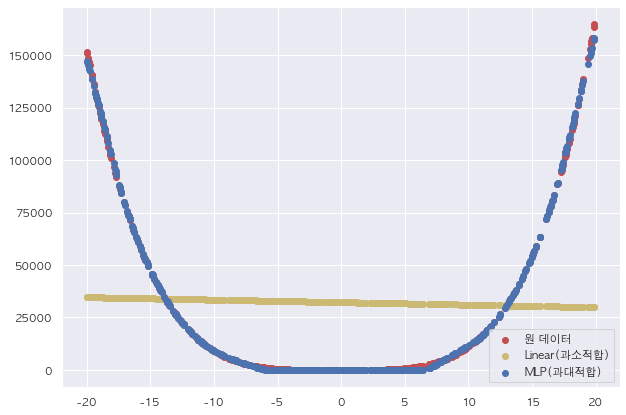

In [127]:
# 학습 결과 시각화
plt.scatter(x, y, c='r', label='원 데이터')
plt.scatter(x, model_lr.predict(x), c='y', label='Linear(과소적합)')
plt.scatter(x, model_nn.predict(x), c='b', label='MLP(과대적합)')
plt.legend()
plt.show()

LinearRegressor: 데이터를 전혀 설명하지 못한다 -> 과소적합

MLPRegressor: 학습 데이터에 최적화된 데이터를 만든다 -> 학습 데이터에 최적화 되면 새로운 데이터(테스트 데이터)에 대한 예측이 어긋날 수 있다, 과대적합의 위험